In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import integrate
import timeit
import warnings
import copy
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from numpy import random
import math
from tqdm import tqdm 

warnings.filterwarnings("ignore", category=RuntimeWarning)
K = 99 # strike price
S0 = 100 # current price of the stock
N = 50 # time steps for each path
sigma = 0.2 # volatility
r = 0.06 # risk free rate 
T = 1 # year

In [2]:
from numba import njit, prange

In [3]:
def blackschol(St, K, sigma, r, T, t, optiontype='call'):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    d1 = (1 / sigma * np.sqrt(T-t))*( np.log(St/K) + (r + (sigma**2/2))*(T-t))
    d2 = (1 / sigma * np.sqrt(T-t))*( np.log(St/K) + (r - (sigma**2/2))*(T-t))
    
    if optiontype == 'call':
        value = norm.cdf(d1)* St - norm.cdf(d2)* K * np.exp(-r *(T-t))
    elif optiontype == 'put':
        value = norm.cdf(-1*d2) * K * np.exp(-r *(T-t))  - norm.cdf(-1*d1)* St 
    
    return value

#@njit(parallel = True)
def GBM(K, S0, sigma, r, T):
    Z = random.normal(0,1)
    S_T = S0*math.exp((r-0.5*sigma**2)*T + sigma*math.sqrt(T)*Z)
    return S_T

#@njit(parallel = True)
def Payoff(K, S0, N, sigma, r, T, optiontype = 'put',digital=False):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    S_N = GBM(K, S0, sigma, r, T)
    if digital == False:
        if optiontype=='put':
                payment = max(K - S_N,0)
        elif optiontype=='call':
                payment = max(S_N - K,0)
    else:
        if K<S_N:   
            payment = 1
        else:
            payment = 0
    return payment

def MC_DAVPO(K, S0, N, sigma, r, T, M,optiontype='put'):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    payoff_list = np.zeros(M)
    for i in range(M):
        S_N = GBM(K, S0, sigma, r, T)
        payoff_list[i] = Payoff(K, S0, N, sigma, r, T, optiontype ,digital=False)

    V = math.exp(-1*r*T)*np.mean(payoff_list)
    std_MC = np.std(payoff_list)/math.sqrt(M)
    
    return V,std_MC


def MC_digi(K, S0, N, sigma, r, T, M):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    payoff = np.zeros(M)
    for i in range(M):
        S_N = GBM(K, S0, sigma, r, T)
        if K<S_N:   
            payoff[i] = 1
        else:
            payoff[i] = 0

    V = math.exp(-1*r*T)*np.mean(payoff)
    std_payoff = np.std(payoff)
    std_MC = std_payoff/math.sqrt(M)
    return V,std_MC

### MC simulation

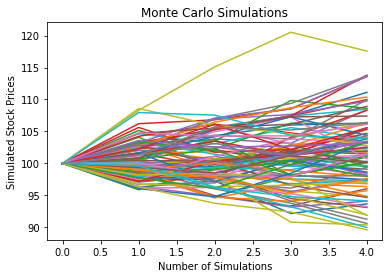

In [4]:
def MC_simulation(S0=100, r=0.06,sigma=0.2,N =50,T=1, nSims=100):

    dt = T/N
    mu = (r-0.5*sigma**2)*dt
    sigma = sigma*np.sqrt(dt)
    St = np.zeros(shape=(N,nSims))
    St[0,] = S0
    for i in range(1,N):
            for j in range(0,nSims):
                e = random.normal(0,1)
                St[i,j] = St[i-1,j]*np.exp(mu+sigma*e)
    return St
plt.plot(pd.DataFrame(MC_simulation()).head())
plt.title("Monte Carlo Simulations")
plt.xlabel("Number of Simulations")
plt.ylabel("Simulated Stock Prices")
plt.show()

Black Schole's Value: 4.778969051891714
(5.271689908311721, 0.9211884214482344)
(4.928678541963597, 0.2739162622764074)
(4.969009029647376, 0.08614520708763228)
(4.763014938149791, 0.026775356134635882)
(4.776422292407045, 0.00846909735149522)
(4.78200906339209, 0.002680110619413865)


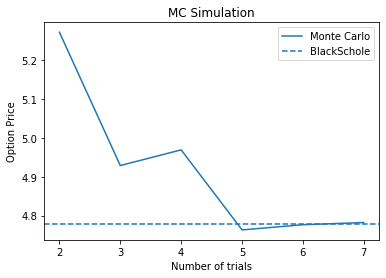

In [5]:
BS = blackschol(S0, K, sigma, r, T, 0, optiontype='put')
print("Black Schole's Value:", BS)

x_range = []
MC_simulation = []
for i in range(2,8):
    M=10**i
    MC_result = MC_DAVPO(K, S0, N, sigma, r, T, M, optiontype='put')
    print(MC_result) # print mean and sdandard error
    x_range.append(i)
    MC_simulation.append(MC_result[0])

plt.plot(x_range, MC_simulation, label = 'Monte Carlo')
plt.axhline(y=BS,ls="--", label = 'BlackSchole')

plt.ylabel('Option Price')
plt.xlabel('Number of trials')
plt.title('MC Simulation')
plt.legend()
plt.show()

### Bump-and-revalue 

In [6]:
# Different seeds

M = 1000
eps = 0.5
hedge_param = []
V_eps = []
V_0 = []

for i in range(M): 
    V_eps.append(Payoff(K, S0+eps, N, sigma, r, T, optiontype = 'put',digital=False))
    V_0.append(Payoff(K, S0, N, sigma, r, T, optiontype = 'put',digital=False))
    hedge_param.append((V_eps[i] - V_0[i])/eps)
    
print("The mean and variance of delta:")
print(np.mean(hedge_param), np.var(hedge_param))

The mean and variance of delta:
0.8307362330317993 557.8366120019441


In [7]:
# Same seeds

M = 1000
eps = 0.5
hedge_param = []
V_eps = []
V_0 = []

random.seed(123)
for i in range(M): 
    V_eps.append(Payoff(K, S0+eps, N, sigma, r, T, optiontype = 'put',digital=False))

random.seed(123)
for i in range(M):
    V_0.append(Payoff(K, S0, N, sigma, r, T, optiontype = 'put',digital=False))

for i in range(M):
    #hedge_param.append((V_eps[i] - V_0[i])/eps)
    hedge_param.append((V_eps[i] - V_0[i])/eps)

print("The mean and variance of delta:")
print(np.mean(hedge_param), np.var(hedge_param))

#theoretical std of hedge_param
var_theo = (np.cov(V_eps,V_0)[0,0] + np.cov(V_eps,V_0)[1,1] - 2*np.cov(V_eps,V_0)[0,1])/(eps*eps)
print("The estimated variance of delta:")
print(var_theo)

The mean and variance of delta:
-0.3478812525028487 0.17975090376887906
The estimated variance of delta:
0.179930834602942


### Digital option

In [8]:
# Different seeds

M = 1000
eps = 0.5
hedge_param = []
V_eps = []
V_0 = []

for i in range(M): 
    V_eps.append(Payoff(K, S0+eps, N, sigma, r, T, optiontype = 'put',digital=True))
    V_0.append(Payoff(K, S0, N, sigma, r, T, optiontype = 'put',digital=True))
    hedge_param.append((V_eps[i] - V_0[i])/eps)

print("The mean and variance of delta:")
print(np.mean(hedge_param), np.var(hedge_param))

#theoretical std of hedge_param
var_theo = (np.cov(V_eps,V_0)[0,0] + np.cov(V_eps,V_0)[1,1] - 2*np.cov(V_eps,V_0)[0,1])/(eps*eps)
print("The estimated variance of delta:")
print(var_theo)

The mean and variance of delta:
0.006 1.923964
The estimated variance of delta:
1.9258898898898902


In [9]:
# Same seeds

M = 1000
eps = 0.5
hedge_param = []
V_eps = []
V_0 = []

random.seed(235)
for i in range(M): 
    V_eps.append(Payoff(K, S0+eps, N, sigma, r, T, optiontype = 'put',digital=True))

random.seed(235)
for i in range(M):
    V_0.append(Payoff(K, S0, N, sigma, r, T, optiontype = 'put',digital=True))

for i in range(M):
    hedge_param.append((V_eps[i] - V_0[i])/eps)

print("The mean and variance of delta:")
print(np.mean(hedge_param), np.var(hedge_param))

#theoretical std of hedge_param
var_theo = (np.cov(V_eps,V_0)[0,0] + np.cov(V_eps,V_0)[1,1] - 2*np.cov(V_eps,V_0)[0,1])/(eps*eps)
print("The estimated variance of delta:")
print(var_theo)

The mean and variance of delta:
0.032 0.06297600000000002
The estimated variance of delta:
0.06303903903903385


### Digital option - sophisticated methods

In [10]:
#Likelihood Ratio method
LR_result = []
M=1000

#@njit(parallel = True)
def LR_payoff(K, S0, sigma, r, T):
    Z = random.normal(0,1)
    S_T = S0*math.exp((r-0.5*sigma**2)*T + sigma*math.sqrt(T)*Z)
    if K<S_T:   
        payment = 1
    else:
        payment = 0
    return payment,Z

for i in range(M):
    I,Z = LR_payoff(K, S0, sigma, r, T)
    LR_result.append(math.exp(-1*r*T)*I*Z/(S0*sigma*math.sqrt(T)))

print("The mean and variance of delta:")
print(np.mean(LR_result),np.var(LR_result))

The mean and variance of delta:
0.016923862769441227 0.0007247146165394803


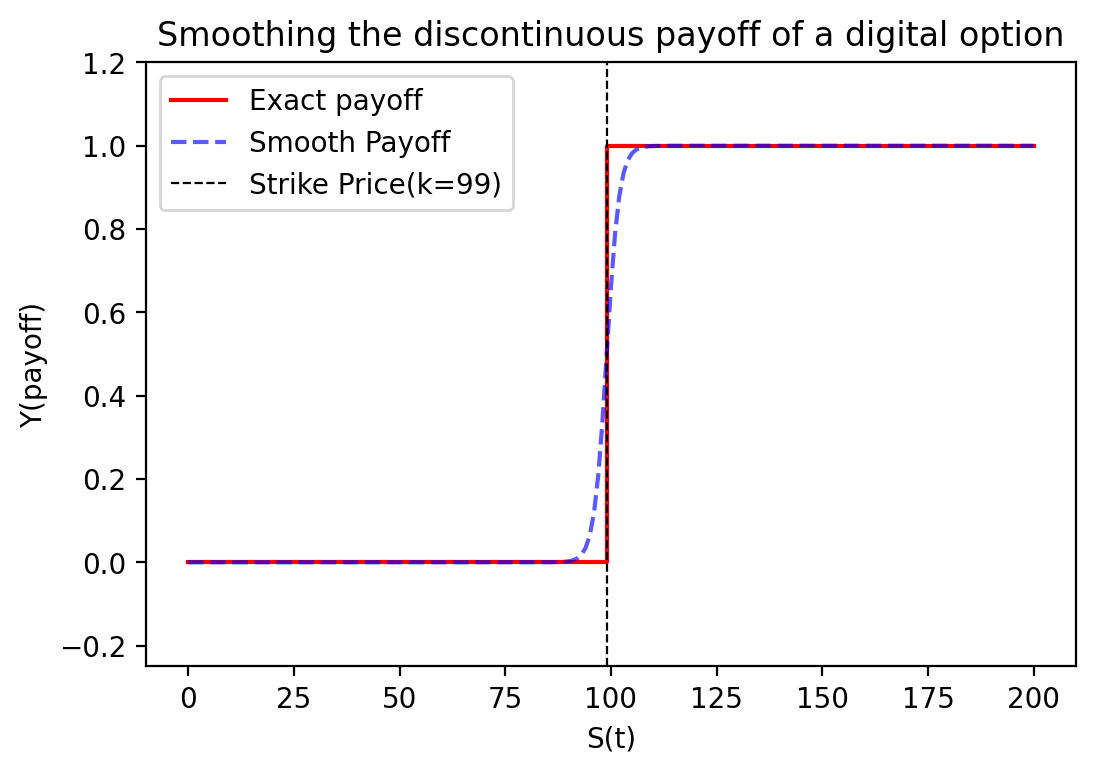

In [11]:
#Pathwise method

x = np.arange(0,201)
#y = (1+np.exp(-(x-99)/0.1))**-1

y = np.heaviside(x-99,0)

y_smooth = 0.5*(np.tanh((x-99)/3)+1)

fig, ax = plt.subplots(dpi=200)
ax.set_title('Smoothing the discontinuous payoff of a digital option')
ax.step(x,y,'r',label='Exact payoff')
ax.plot(x,y_smooth,'--',color='b',alpha=0.65,label='Smooth Payoff')
ax.set_ylabel('Y(payoff)')
ax.set_ylim(-0.25,1.2)
ax.set_xlabel('S(t)')
ax.axvline(x=99, ls='--', lw=0.8, color='k',label='Strike Price(k=99)')
ax.legend()
plt.show()

In [12]:
d2= (np.log(S0/K)+T*(r-(0.5*sigma**2)))/(sigma*np.sqrt(T))
delta = (norm.pdf(d2)*np.exp(-r*T))/(sigma*S0*np.sqrt(T))
print("Exact Delta from Black-Scholes: ", delta)

Exact Delta from Black-Scholes:  0.018206369779490493


In [13]:
# Numerical Integration using Scipy integarte
eps=0.2
func1 = lambda S: (np.exp(-1*r*T)/(2*eps*S0*np.sqrt(2*T*np.pi*sigma**2)))*(1-(np.tanh((S-K)/eps))**2)*np.exp((-(np.log(S/S0)-(r-(0.5*sigma**2))*T)**2)/(2*T*sigma**2))

print("Delta using Scipy's numerical integration: ", integrate.quad(func1, 85, np.inf)[0])

Delta using Scipy's numerical integration:  0.01820561553526922


In [14]:
func2 = lambda S: (1/S**2)*(np.exp(-1*r*T)/(2*eps*S0*np.sqrt(2*T*np.pi*sigma**2)))*(1-(np.tanh(((1/S)-K)/eps))**2)*np.exp((-(np.log(1/(S*S0))-(r-(0.5*sigma**2))*T)**2)/(2*T*sigma**2))

#@njit(parallel = True)
def MC_integrate(num_samples=10**5):
   
    sum_of_samples1 = 0
    sum_of_samples2 =0
    for i in range(num_samples):
        x = np.random.uniform(0,1)
        sum_of_samples1 += func1(x)
        
    for i in range(num_samples):
        x = np.random.uniform(0,1)
        sum_of_samples2 += func2(x)  
     
    I1 =  (sum_of_samples1/num_samples)
    I2 =  (sum_of_samples2/num_samples)
    return I1 + I2

print("Delta using Monte carlo integration: ", MC_integrate(500000))

Delta using Monte carlo integration:  0.016384758395766415


In [15]:
epslist = np.linspace(0,0.25,100)[1:]
numerical = []
montecarlo = []
for eps in tqdm(epslist):
    numerical.append(integrate.quad(func1, 90, np.inf)[0])
    montecarlo.append(MC_integrate())

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [03:46<00:00,  2.29s/it]


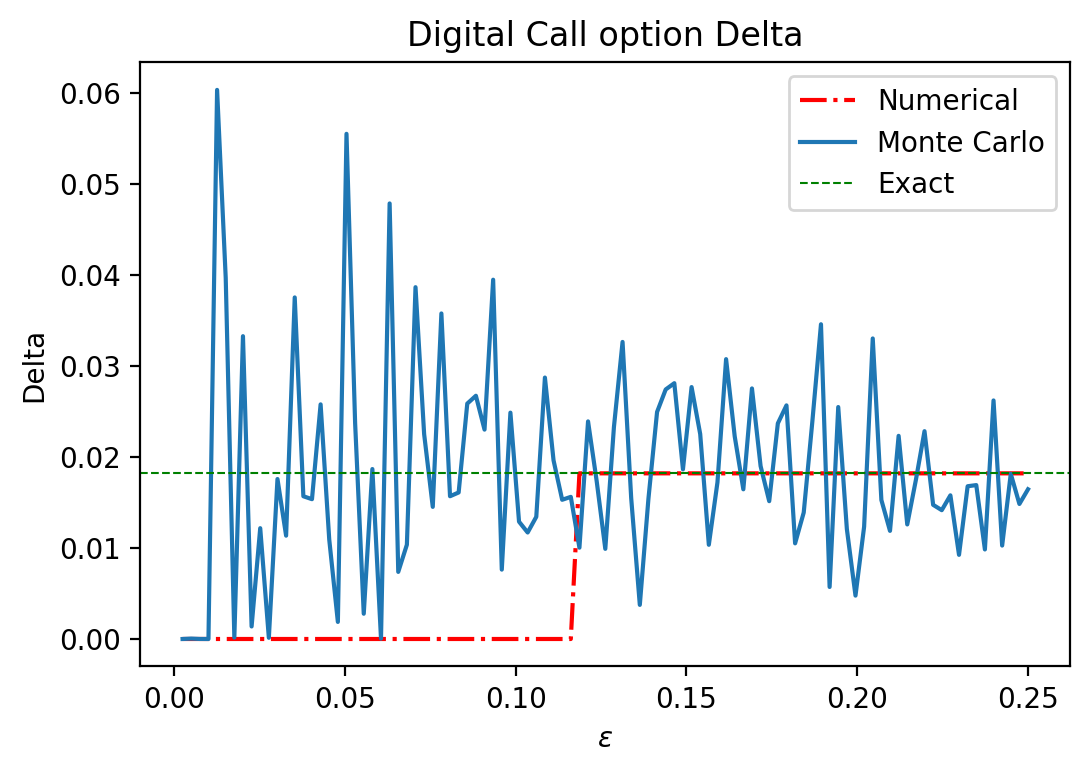

In [16]:
fig, ax = plt.subplots(dpi=200)
ax.plot(epslist,numerical,ls='dashdot',color='r',label='Numerical')
ax.plot(epslist,montecarlo,label='Monte Carlo')
ax.axhline(y=delta, ls='--',lw=0.75,color='g',label = 'Exact')
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"Delta")
ax.set_title("Digital Call option Delta")
ax.legend()
plt.show()

### Asian option

In [19]:
def Analytical_Geo_AsianCall(S0=100, K=99, sigma=0.2, r=0.06, T=1, N=50):
    sigma_new = sigma*np.sqrt((2*N+1)/(6*N+6))
    r_new = ((r-0.5*sigma**2)+sigma_new**2)/2

    d1_new = (np.log(S0/K) + (r_new + 0.5*sigma_new**2)*T)/(sigma_new*np.sqrt(T))
    d2_new = (np.log(S0/K) + (r_new - 0.5*sigma_new**2)*T)/(sigma_new*np.sqrt(T))
    
    value = np.exp(-1*r*T)*(S0*np.exp(r_new*T)*norm.cdf(d1_new) - K*norm.cdf(d2_new))
    return value

@njit(parallel = True)
def Geo1_payoff(S0=100, K=99, sigma=0.2, r=0.06, T=1, N=50):
    Sum = S0**(N+1)
    
    for i in range(N):
        X = random.normal(0,1)
        At = np.exp((r-0.5*sigma**2)*T/N + sigma*np.sqrt(T/N)*X)
        Sum = Sum*(At**(N-i))

    #Calculate geometric averages
    AN = Sum**(1/(N+1))
    
    payoff = max(AN-K,0)
    return payoff

@njit(parallel = True)
def GBM_path(S0=100, K=99, sigma=0.2, r=0.06, T=1, N=50):
    dt = T/N
    St = np.zeros(N)
    St[0] = S0
    mu = (r-(0.5*sigma**2))*dt
    sigma = sigma*np.sqrt(dt)
    for i in range(1, N):
        e = random.normal(0,1)
        St[i] = St[i-1]*np.exp(mu+sigma*e)
    
    return St

@njit(parallel = True)
def Arith_payoff(path,K=99):
    payoff = max(np.mean(path)-K,0)
    return payoff

@njit(parallel = True)
def Geo_payoff(path, K=99):
    payoff = max(np.exp(np.mean(np.log(path)))-K, 0)
    return payoff

#@njit(parallel = True)
def MC_Geo_Asian(K=99, S0=100, N=50, sigma=0.2, r=0.06, T=1, M=10**4):
    geo_pay = np.zeros(M)
    for i in range(M):
        path = GBM_path(S0, K, sigma, r, T, N)
        geo_pay[i] = Geo_payoff(path, K)
    
    geo_mean = np.mean(geo_pay)
    geo_error = np.std(geo_pay)/np.sqrt(M)
    
    return geo_mean, geo_error
    

def arith_AsianCall_MC_withoutCV(S0=100, sigma=0.2, K=99, r=0.06, T=1, N=50, M = 10**4):

    arith_payoff = np.zeros(M)
    for i in range(M):
        path = GBM_path(S0, K, sigma, r, T, N)
        arith_payoff[i] = Arith_payoff(path,K)
        
    arithMC  = np.mean(arith_payoff)
    #arithMC_error = np.std(arith_payoff)/np.sqrt(M)
    
    return arithMC

def b_star(r=0.06, sigma=0.2 , T=1 ,N=50, S0=100 ,K=99, simsb=100 ): #Estimates optimal control variate coefficient
    geo = np.zeros(simsb)
    ari = np.zeros(simsb)
    for n in range(simsb):
        path = GBM_path(S0, K, sigma, r, T, N)
        geo[n]= Geo_payoff(path, K)
        ari[n]= Arith_payoff(path, K)
    S_xy=0
    Var_x=0
    for n in range (0 , simsb):
        S_xy += (geo[n] - np.mean(geo)) * (ari[n] - np.mean(ari))
        Var_x += (geo[n] - np.mean(geo))**2
    return S_xy/Var_x 

def arith_Asiancall_MC_CV(b, S0=100, sigma=0.2, K=99, r=0.06, T=1, N=50, M = 10**4): #Estimates expected payoff from arithmetic Asian with controlvariate
    geo = np.zeros(M)
    ari = np.zeros(M)
    for n in range(M):
        path = GBM_path(S0, K, sigma, r, T, N)
        ari[n]= Arith_payoff(path, K)
        geo[n]= Geo_payoff(path, K) - Analytical_Geo_AsianCall(S0, K, sigma, r, T, N)
        
    result = np.mean(ari) - b*np.mean(geo)
    return result

In [20]:
Asian_analytic = Analytical_Geo_AsianCall()
print("The analytical price of an Asian call option based on geometric average: ", Asian_analytic)

The analytical price of an Asian call option based on geometric average:  6.310747867416329


(6.268272730468006, 0.7960915210995517)
(6.641183000971964, 0.2618615644551895)
(6.643837182037137, 0.08590291213347002)
(6.562494748064477, 0.026610380760086448)
(6.6184101448108, 0.008475996726155998)


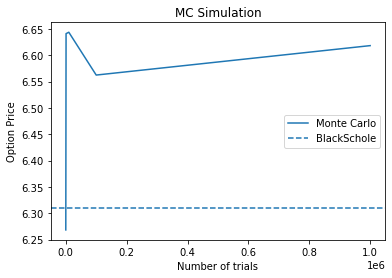

In [21]:
# Monte Carlo simulation using geometric averages

x_range = []
MC_result = []
for i in range(2,7):
    m=10**i
    result = MC_Geo_Asian(M=m) #print mean and sdandard error
    print(result)
    x_range.append(m)
    MC_result.append(result[0])

plt.plot(x_range, MC_result, label = 'Monte Carlo')
plt.axhline(y=Asian_analytic,ls="--", label = 'BlackSchole')

plt.ylabel('Option Price')
plt.xlabel('Number of trials')
plt.title('MC Simulation')
plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.88s/it]


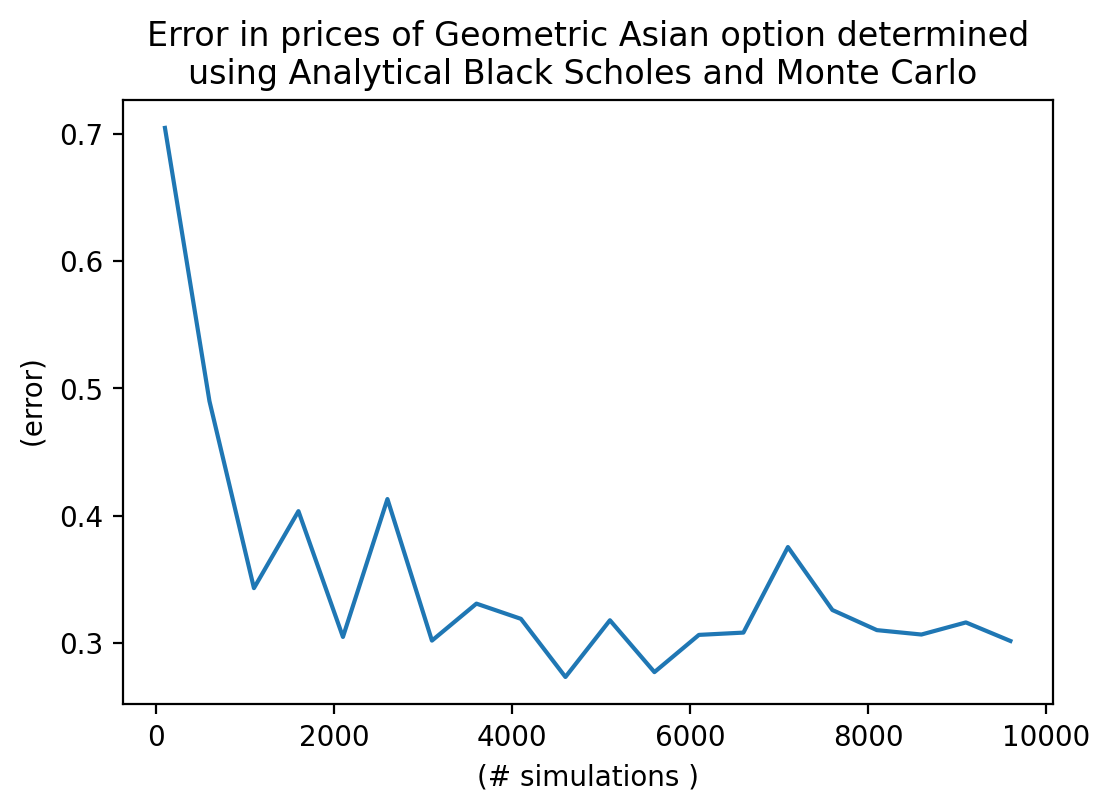

In [23]:
sims_vector  =  np.arange(10**2,10**4,500)
error  = np.zeros(len(sims_vector)) 
for x in tqdm(range(len(sims_vector))):
    data =  np.zeros(20)
    sims =  sims_vector[x] 
    for y in range(len(data)):
        data[y]  = np.abs(MC_Geo_Asian(M = sims)[0]- Asian_analytic)
    error[x]= np.mean(data) 
#error2= np.log(error) 
#sims2 = np.log(sims_vector ) 
#plt.plot(sims2 , error2 )
#plt.xlabel( ' log(# simulations ) ' )
#plt.ylabel( ' log (error) ' )
fig, ax = plt.subplots(dpi=200)
ax.plot(sims_vector, error)
ax.set_xlabel('(# simulations )')
ax.set_ylabel(' (error) ')
ax.set_title("Error in prices of Geometric Asian option determined"+"\nusing Analytical Black Scholes and Monte Carlo ")
plt.show()

In [24]:
# Control variate technique 

K_vals = np.arange(50,121,1); withcv_K = []; nocv_K = []
for i in tqdm(range(len(K_vals))):
    B = b_star(K = K_vals[i])
    nocv_K.append(arith_AsianCall_MC_withoutCV(K = K_vals[i])*np.exp(-0.06))
    withcv_K.append(arith_Asiancall_MC_CV(K = K_vals[i],b=B)*np.exp(-0.06))
    
N_vals = np.arange(20,1000,5); withcv_N = []; nocv_N = [] 
for i in tqdm(range(len(N_vals))):
    B = b_star(N = N_vals[i])
    nocv_N.append(arith_AsianCall_MC_withoutCV(N = N_vals[i])*np.exp(-0.06))
    withcv_N.append(arith_Asiancall_MC_CV(N = N_vals[i], b=B)*np.exp(-0.06))
    


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [10:11<00:00,  3.12s/it]


In [25]:
sim_vals = np.arange(10**2,3*10**4,500); withcv_sim = []; nocv_sim = []
B = b_star()
for i in tqdm(range(len(sim_vals))):
    nocv_sim.append(arith_AsianCall_MC_withoutCV(M = sim_vals[i])*np.exp(-0.06))
    withcv_sim.append(arith_Asiancall_MC_CV( M = sim_vals[i], b=B)*np.exp(-0.06))

sigma_vals = np.arange(0.1,4,0.1); withcv_sigma = []; nocv_sigma = [] 
for i in tqdm(range(len(sigma_vals))):
    B = b_star(sigma = sigma_vals[i])
    nocv_sigma.append(arith_AsianCall_MC_withoutCV(sigma = sigma_vals[i])*np.exp(-0.06))
    withcv_sigma.append(arith_Asiancall_MC_CV(sigma = sigma_vals[i],b=B)*np.exp(-0.06))

r_vals = np.arange(0,1.5,0.01); withcv_r = []; nocv_r = []
for i in tqdm(range(len(r_vals))):
    B = b_star(r = r_vals[i])
    nocv_r.append(arith_AsianCall_MC_withoutCV(r = r_vals[i])*np.exp(-r_vals[i]))
    withcv_r.append(arith_Asiancall_MC_CV(r = r_vals[i],b=B)*np.exp(-r_vals[i]))

T_vals = np.arange(1,10,0.5); withcv_T = []; nocv_T = []
for i in tqdm(range(len(T_vals))):
    B = b_star(T = T_vals[i])
    nocv_T.append(arith_AsianCall_MC_withoutCV(T = T_vals[i])*np.exp(-0.06*T_vals[i]))
    withcv_T.append(arith_Asiancall_MC_CV(T = T_vals[i],b=B)*np.exp(-0.06*T_vals[i]))

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:52<00:00,  2.93s/it]


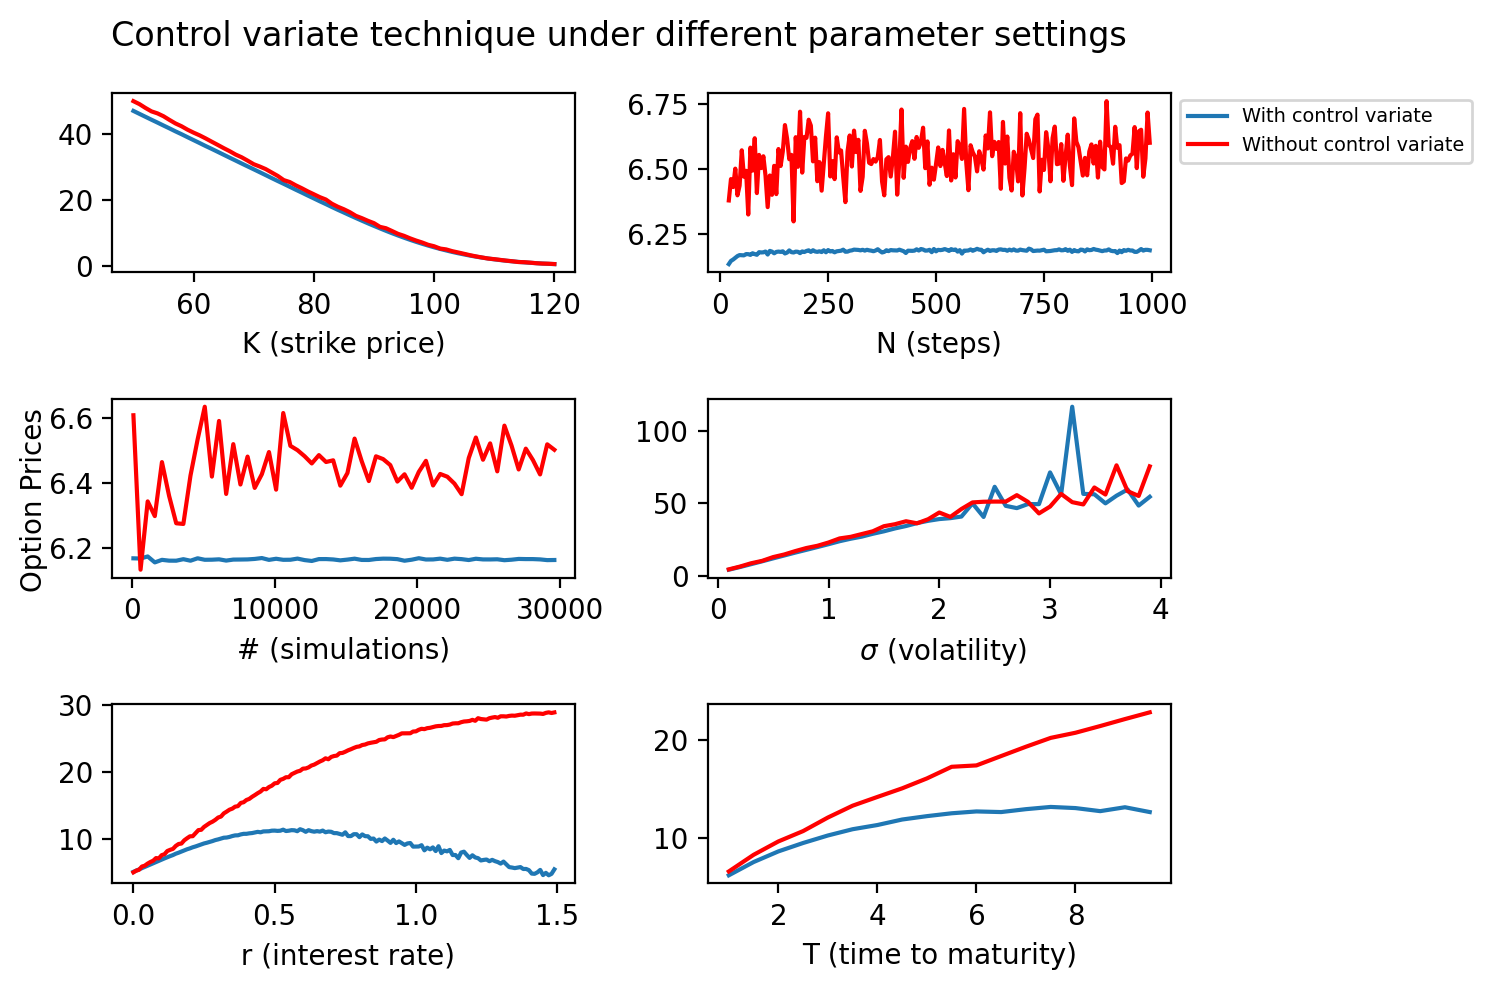

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=2 , figsize=(6,5),dpi=200)
axs[0,0].plot(K_vals , withcv_K , label = "With control variate" )
axs[0,0].plot(K_vals , nocv_K , c='r' , label = "Without control variate" )
axs[0,0].set_xlabel( "K (strike price)" )
#axs[0,0].legend()
axs[0,1].plot(N_vals , withcv_N , label = "With control variate" )
axs[0,1].plot(N_vals , nocv_N , c='r' , label = "Without control variate" )
axs[0,1].set_xlabel( "N (steps)" )
#axs[0,1].legend()
axs[1,0].plot(sim_vals , withcv_sim , label = "With control variate" )
axs[1,0].plot(sim_vals , nocv_sim , c='r' , label = "Without control variate" )
axs[1,0].set_xlabel( "# (simulations)" )
#axs[1,0].legend()
axs[1,1].plot(sigma_vals , withcv_sigma , label = "With control variate" )
axs[1,1].plot(sigma_vals , nocv_sigma , c='r' , label = "Without control variate" )
axs[1,1].set_xlabel( r" $\sigma$ (volatility)" )
axs[2,0].plot(r_vals , withcv_r , label = "With control variate" )
axs[2,0].plot(r_vals , nocv_r , c='r' , label = "Without control variate" )
axs[2,0].set_xlabel( " r (interest rate)" )
axs[2,1].plot(T_vals , withcv_T , label = "With control variate" )
axs[2,1].plot(T_vals , nocv_T , c='r' , label = "Without control variate" )
axs[2,1].set_xlabel( "T (time to maturity)" )
fig.text(0.001, 0.5, 'Option Prices', va='center', rotation='vertical')
fig.suptitle("Control variate technique under different parameter settings")
handles, labels = axs[2,1].get_legend_handles_labels()
fig.legend(handles, labels,  bbox_to_anchor=(0.96, 0.91),loc='upper left',fontsize='x-small')
fig.tight_layout()
plt.show()